In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

from time_series_influences.utils import split_time_series, match_train_time_block_index
from time_series_influences.anomaly_detection import scale_influence_functions, eval_anomaly_detector
from time_series_influences.block_selection import compute_optimal_block_length
from time_series_influences.nonparametric_influences import compute_nonparametric_influences

seed = 666
np.random.seed(seed)

In [2]:
data_path = "../data/univariate/UCR/data/"
data_dir = Path("../data/univariate/UCR/data/")
# for file_name in os.listdir(data_path):
#     if int(file_name[:3]) < 204:
#         ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
#         file_name_list = file_name[:-4].split('_')
#         train_id, anomaly_start, anomaly_end = int(file_name_list[4]),int(file_name_list[5]),int(file_name_list[6])
#         ts = ts.squeeze()
#         ground_truth = np.zeros_like(ts)
#         ground_truth[anomaly_start:anomaly_end] = 1.
#         print('Dataset:',file_name_list[0]+'_'+file_name_list[3])
#         print('Num. of Training: ',train_id)
#         print('Num. of Test: ',len(ts)-train_id)
#         print('Len. of Anomaly: ',anomaly_end-anomaly_start)
#         print('Anomaly Ratio:', float((anomaly_end-anomaly_start))/len(ts))

#### point outlier detection

In [3]:
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 17210, 17260
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

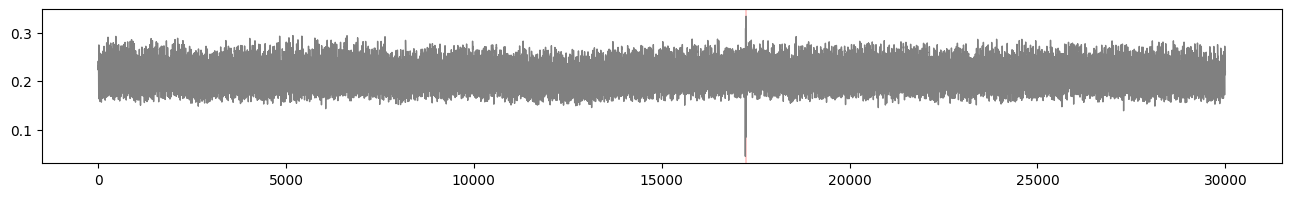

In [4]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [5]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  52


In [6]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29949, 52) (29949,)


In [10]:
n = len(X_train)
m = int(0.7 * n)
t = 1000
learner = MLPRegressor()
metric = mean_squared_error
time_block_loos = compute_nonparametric_influences(X_train, Y_train, t, m, learner, metric)

100%|█████████████████████████████████████| 29949/29949 [05:02<00:00, 98.86it/s]


In [11]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

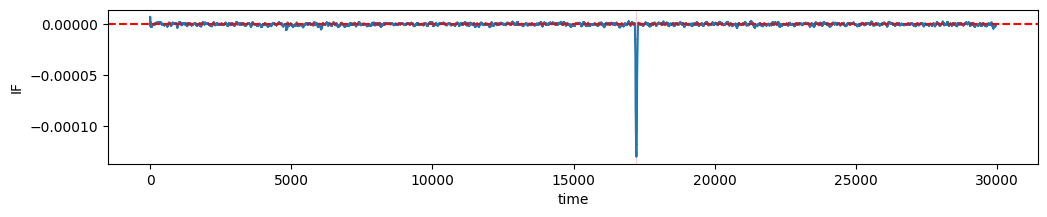

In [12]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [13]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length=block_length)

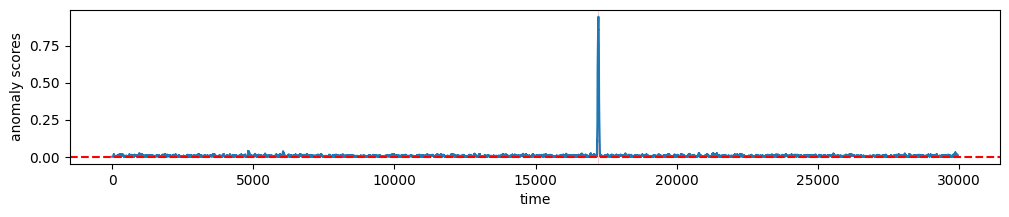

In [14]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [15]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

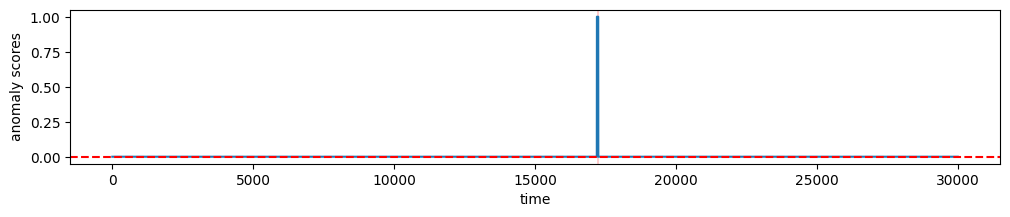

In [16]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [17]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.660 recall: 0.660 F1: 0.660 AUC: 1.000


#### change point detection

In [18]:
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 12190, 12420
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

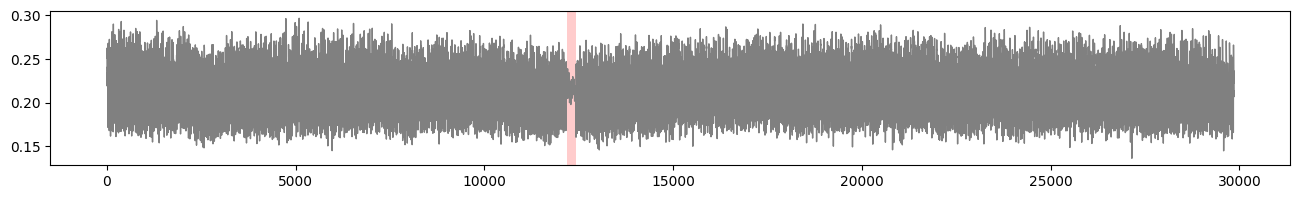

In [19]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [20]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  52


In [21]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29807, 52) (29807,)


In [22]:
n = len(X_train)
m = int(0.7 * n)
t = 1000
learner = MLPRegressor()
metric = mean_squared_error
time_block_loos = compute_nonparametric_influences(X_train, Y_train, t, m, learner, metric)

100%|████████████████████████████████████| 29807/29807 [04:26<00:00, 112.05it/s]


In [23]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

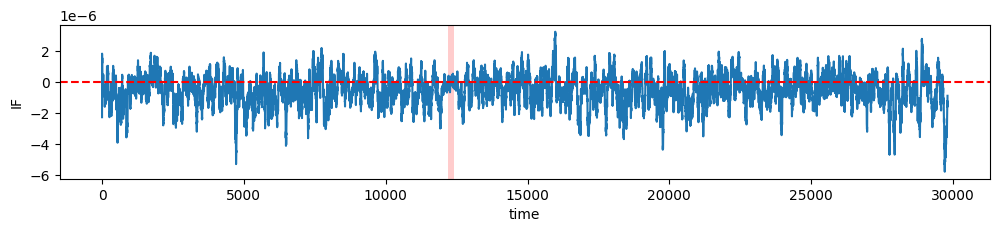

In [24]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [25]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

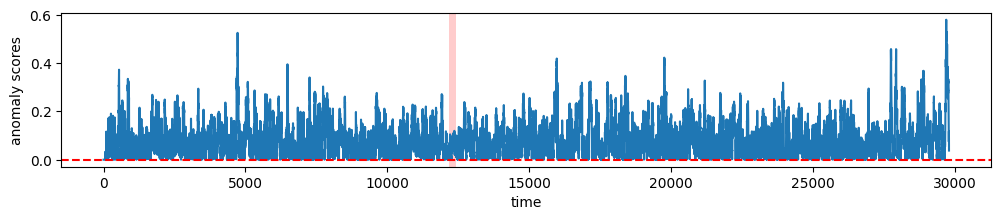

In [26]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [27]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

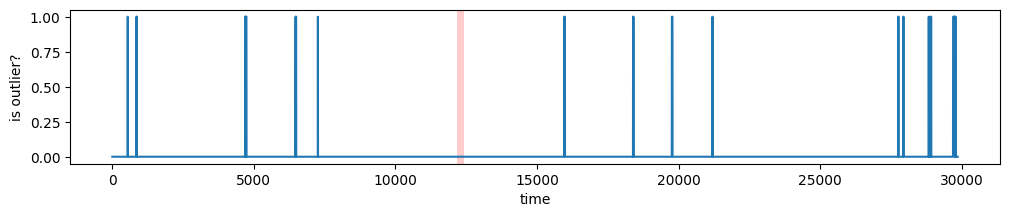

In [28]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [29]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.425


#### anomaly pattern detection

In [30]:
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 33070, 33180
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

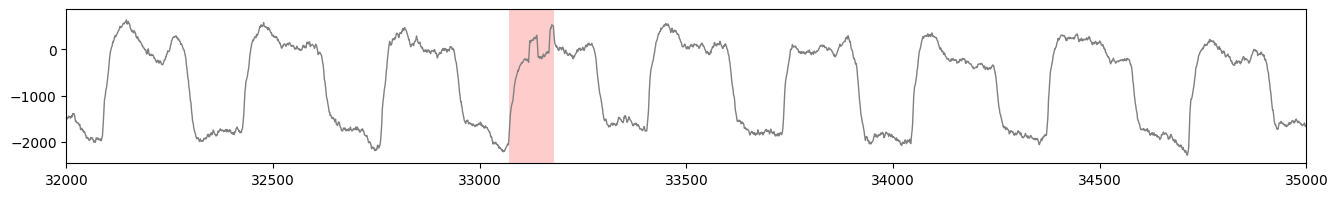

In [31]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(32000, 35000)
plt.show()

In [32]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  40


In [33]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(63960, 40) (63960,)


In [ ]:
n = len(X_train)
m = int(0.7 * n)
t = 1000
learner = MLPRegressor()
metric = mean_squared_error
time_block_loos = compute_nonparametric_influences(X_train, Y_train, t, m, learner, metric)

In [34]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

In [ ]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [36]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

In [ ]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [38]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

In [ ]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [ ]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

#### noise detection

In [3]:
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 46600, 46900
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

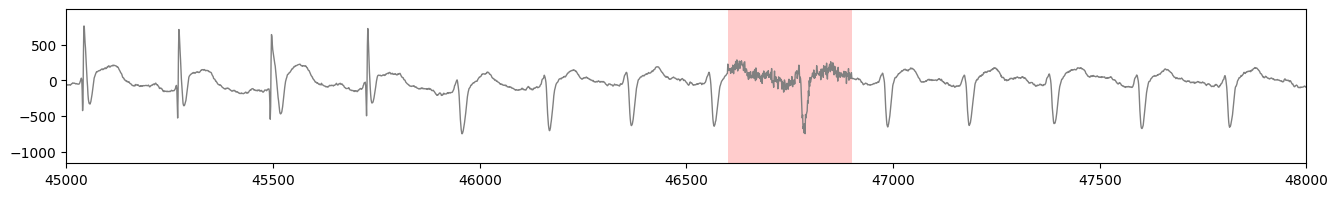

In [4]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(45000, 48000)
plt.show()

In [5]:
block_length = compute_optimal_block_length(ts, 1000, 3000)

The optimal block length is:  16


In [6]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(79984, 16) (79984,)


In [ ]:
n = len(X_train)
m = int(0.7 * n)
t = 1000
learner = MLPRegressor()
metric = mean_squared_error
time_block_loos = compute_nonparametric_influences(X_train, Y_train, t, m, learner, metric)

In [ ]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

In [ ]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [48]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

In [ ]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [50]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

In [ ]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [52]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.650 recall: 0.650 F1: 0.650 AUC: 0.998
